In [21]:
import pandas as pd
from openai import OpenAI # gotta upgrade openai to newest version if already installed: pip install --upgrade openai
from tqdm import tqdm
from joblib import Parallel, delayed
import random

# GPT labelling

In [23]:
df1 = pd.read_csv("human_eval/human_sent_eval_0_labeled.csv")
df2 = pd.read_csv("human_eval/human_sent_eval_1_labeled.csv")

df = pd.concat([df1, df2])

In [27]:
def gpt_sentiment_classification(post_text: str):
    try:
        
        # Set the OpenAI API key to a specific value
        client = OpenAI(
            # defaults to os.environ.get("OPENAI_API_KEY")
            api_key=""
        )
        system_prompt = """
        Categorize the provided reddit post as "positive" if the post is positive about bitcoin, "negative" if it is negative about bitcoin. If none of these categories are applicable or it is unclear, please respond with "none/unclear". Respond briefly with "positive", "negative", or "none/unclear".
        """
        
        prompt = "Post: " + post_text

        response = client.chat.completions.create(
                                            model="gpt-4o", 
                                            messages = [{"role": "system", "content": system_prompt}, 
                                            {"role": "user", "content": prompt}], temperature=0
                                            )

        answer = response.choices[0].message.content.strip()

        return answer, post_text
    except Exception as e:
        print(e)
        return None, None

text = df["selftext"].tolist()
out = Parallel(n_jobs=-1)(delayed(gpt_sentiment_classification)(post) for post in tqdm(text))

100%|██████████| 100/100 [00:03<00:00, 26.50it/s]


In [30]:
sentiments, posts = zip(*out)

In [33]:
df["gpt_sentiment"] = sentiments

# Map sentiment to 1, 0, -1
sentiment_map = {"positive": 1, "negative": -1, "none/unclear": 0}
df["gpt_sentiment"] = df["gpt_sentiment"].map(sentiment_map)

In [34]:
df.to_csv("human_eval/human_sent_eval_gpt_labeled.csv", index=False)

# Roberta Labelling

# Analysis

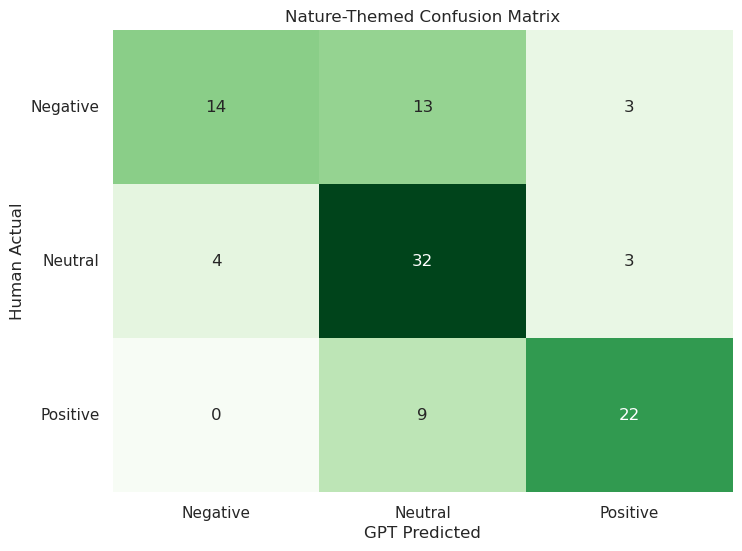

In [42]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Replace 'df' with your actual DataFrame variable name
human_sent = df["human_label"].tolist()
gpt_sent = df["gpt_sentiment"].tolist()

# Mapping numeric labels to textual labels
labels_dict = {-1: "Negative", 0: "Neutral", 1: "Positive"}
human_sent_labels = [labels_dict[label] for label in human_sent]
gpt_sent_labels = [labels_dict[label] for label in gpt_sent]

matrix = confusion_matrix(human_sent_labels, gpt_sent_labels, labels=["Negative", "Neutral", "Positive"])

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap="Greens", cbar=False)
ax.set_xticklabels(["Negative", "Neutral", "Positive"])
ax.set_yticklabels(["Negative", "Neutral", "Positive"], rotation=0)
plt.xlabel('GPT Predicted')
plt.ylabel('Human Actual')
plt.title('Nature-Themed Confusion Matrix')
plt.show()

